<h2>American Call Option Pricing on a Dividend Paying Stock</h2>
<h3>Group No.1</h3>

<h3>Import Libraries</h3>

In [1]:
import math

import numpy as np
import re
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(5)

<h3>Helper Functions</h3>

In [2]:
def f_indicator(boolean):
    return 1 if boolean else 0

In [3]:
def geometric_brownian_motion(z, t, s_0, mu, sigma):
    '''
    Simulate geometric brownian motion according to a given random normal distribution and time stamps
    ---------------------------
    Parameters
    z: array of standard normal distribution with size n
    t: list of time stamps with size n+1
    
    Return
    s: array of geometric brownian motion with size n+1 
    '''
    s = np.repeat(s_0, len(z)+1)
    for i in range(1, len(z)+1):
        s[i] = s[i-1]*math.exp((mu-0.5*sigma**2)*(t[i]-t[i-1])+sigma*z[i-1]*(t[i]-t[i-1])**0.5)
    return s

In [4]:
def real_stock_price_movement(s, t, r, dividends, t_dividends):
    '''
    Map geometric brownian motion simulation result to real stock price by adjusting with respect to 
    the dividend pay
    -----------------------------
    Parameters
    s: array of geometric brownian motion sample with size n+1
    t: array of time stamp corresponding to each sample with size n+1
    r: interest rate
    dividends: list of possible dividend
    t_dividends: list of time of dividend pay
    
    Return
    s_real: array of stock price movement with dividend correction
    '''
    s += get_dividend_adjustment(t, dividends, t_dividends, r)
    return s

In [5]:
def get_dividend_adjustment(t, dividends, t_dividends, r):
    '''
    Get the present value of dividend at time t with a certain dividend scheme specified
    -----------------------------
    Parameters
    t: list of time stamps
    dividends: list of possible dividend
    t_dividends: list of time of dividend pay
    r: interest rate
    
    Return
    d_t: dividend adjustment at time t (inclusive for dividend at time t)
    '''
    d_t = np.zeros(len(t), dtype=np.float32)
    for idx, time_stamp in enumerate(t):
        for t_dividend, dividend in zip(t_dividends, dividends):
            d_t[idx] += f_indicator(time_stamp<=t_dividend)*dividend*math.exp(-r*(t_dividend-time_stamp))
    return d_t

In [6]:
def american_option_payoff(s_real, K, r, t, t_dividends, thresholds):
    '''
    Calculate the payoff of an american option given a strategy defined by thresholds
    ----------------------------
    Parameters
    s_real: array of stock price movement with dividend correction
    K: exercise price
    r: interest rate
    t: list of time stamps for s_real in ascending order
    t_dividends: list of time of dividend pay in ascending order
    thresholds: list of threshold for determining execution of option
    
    Return:
    payoff: payoff from holding the option with a simulated stock price
    '''
    for threshold, t_dividend in zip(thresholds, t_dividends):
        if t_dividend not in t:
            raise ValueError("Some elements of t_dividends are not included in t.")
        idx = t.index(t_dividend)
        if s_real[idx] >= threshold:
            return (s_real[idx] - K) * math.exp(-r*t_dividend)
    return max(0, s_real[-1]-K)*math.exp(-r*t[-1])

In [7]:
def simulate_american_option_payoff(z, t, s_0, mu, sigma, r, K, dividends, t_dividends,thresholds):
    '''
    Simulate american option payoff from an instance of a standard normal vector
    -------------------------------
    Parameters
    z: array of standard normal distribution with size n
    t: list of time stamps with size n+1
    s_0: initial stock price
    r: interest rate
    K: exercise price
    dividends: list of possible dividend
    t_dividends: list of time of dividend pay
    thresholds: list of threshold for determining execution of option

    Return:
    payoff: payoff from holding the option with a simulated stock price
    '''
    s = geometric_brownian_motion(z, t, s_0, mu, sigma)
    s_real = real_stock_price_movement(s, t, r, dividends, t_dividends)
    return american_option_payoff(s_real, K, r, t, t_dividends, thresholds)

<h3>Real stock price simulation example</h3>

<h4>Small Dividend Pay</h4>
<p>This part simulates the real stock price with relatively small dividends comparing to the starting stock price. It is observed that the dividends demonstrate limited effects on the stock price movement.</p>

In [8]:
end_time = 0.9
step_size = 0.005
number_of_step = int(end_time/step_size)

In [9]:
s_0 = 50.
t = [step_size*i for i in range(number_of_step+1)]
t_dividends = [0.3,0.6]
dividends = [2, 2]
mu = 0.1
sigma = 0.2
r = 0.1
initial_adjustment = get_dividend_adjustment([0], dividends, t_dividends, r)[0]

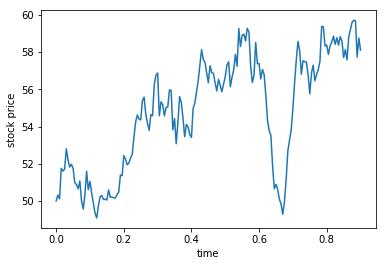

In [10]:
z = np.random.normal(size=number_of_step)
s = geometric_brownian_motion(z, t, s_0-initial_adjustment, mu, sigma)
s_real = real_stock_price_movement(s, t, r, dividends, t_dividends)
plt.xlabel('time')
plt.ylabel('stock price')
plt.plot(t, s_real)

<h4>Large Dividend Pay</h4>
<p>By assigning a high dividend pay, the dividend exhibits a more significant effect on the stock price. Toward the dates of dividend pays, the stock price moves up owning to the increase in present value of dividends.</p>

In [11]:
s_0 = 50.
t = [step_size*i for i in range(number_of_step+1)]
t_dividends = [0.3,0.6]
dividends = [15, 15]
mu = 0.1
sigma = 0.2
r = 0.3
initial_adjustment = get_dividend_adjustment([0], dividends, t_dividends, r)[0]

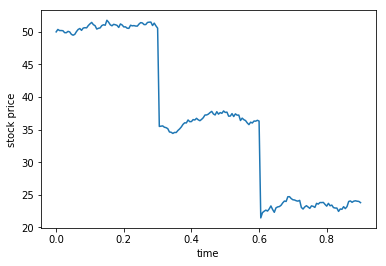

In [12]:
z = np.random.normal(size=number_of_step)
s = geometric_brownian_motion(z, t, s_0-initial_adjustment, mu, sigma)
s_real = real_stock_price_movement(s, t, r, dividends, t_dividends)
plt.xlabel('time')
plt.ylabel('stock price')
plt.plot(t, s_real)

<h3>Properties of Real Stock Price Movement</h3>

<p>By observing the relationship between sigma and payoff, it is reasonable to assume that payoff is an increasing function of sigma in the range of 0.02-0.16.</p>
<p>Therefore, while conducting gradient descent, we may assume that the gradient is always positive if sigma falls into the range.</p>

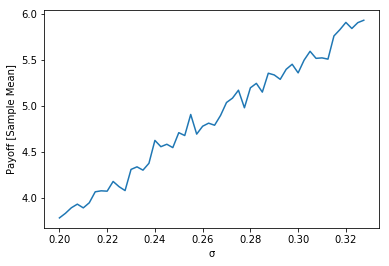

In [13]:
with open('grid_search.txt') as f:
    data = f.readlines()
data = [x.split() for x in data] 
payoff = np.zeros(len(data))
sigmas = np.zeros(len(data))
for idx, line in enumerate(data):
    payoff[idx] = float(line[0])
    sigmas[idx] = float(line[1])

plt.xlabel('\u03C3')
plt.ylabel('Payoff [Sample Mean]')
plt.plot(sigmas, payoff)

<h3>Payoff Simulation</h3>

<h4>Simulates an instance of the real stock price movement for inspection</h4>
<p>The simulations in this section help to verify the correctness of the program by inspections of shapes of generated stock prices of given conditions in the question.</p>

In [14]:
#Problem Parameters
t_dividends = [0.3, 0.6]
t_expiration = 0.9
dividends = [2,2]
thresholds = [60, 60]
s_0 = 50. #starting price
K = 50.  #exercise price
mu = 0.1
sigma = 0.15
r = 0.1 #interest rate
initial_adjustment = get_dividend_adjustment([0], dividends, t_dividends, r)[0]

In [15]:
#Time step parameters
end_time = 0.9
step_size = 0.005
number_of_step = int(end_time/step_size)
t = [step_size*i for i in range(number_of_step+1)]

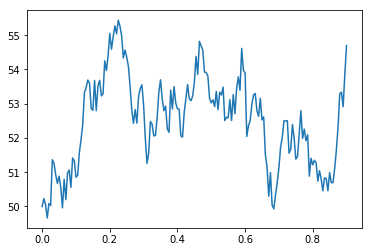

In [16]:
z = np.random.normal(size=len(t)-1)
s = geometric_brownian_motion(z, t, s_0-initial_adjustment, mu, sigma)
s_real = real_stock_price_movement(s, t, r, dividends, t_dividends)
plt.plot(t, s_real)

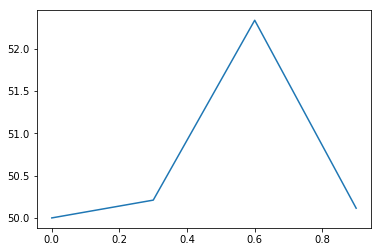

In [17]:
t = [0,0.3,0.6,0.9]
z = np.random.normal(size=len(t)-1)
s = geometric_brownian_motion(z, t, s_0-initial_adjustment, mu, sigma)
s_real = real_stock_price_movement(s, t, r, dividends, t_dividends)
plt.plot(t, s_real)

<h4>Find optimal sigma</h4>
<p>Using gradient descent algorithm, the sigma corresponding to a target option price (4.85) is found.</p>

In [18]:
#Problem Parameters
t = [0,0.3,0.6,0.9]
t_dividends = [0.3, 0.6]
t_expiration = 0.9
dividends = [2,2]
thresholds = [60, 60]
s_0 = 50. #starting price
K = 50 #exercise price
mu = 0.1
r = 0.1 #interest rate
initial_adjustment = get_dividend_adjustment([0], dividends, t_dividends, r)[0]
option_price = 4.85

In [19]:
#Simulation Parameters
sigma = 0.15
n = 60000
valid_sample = 10000
epilson = 1e-5

In [20]:
result = np.zeros(n)
sigmas = np.zeros(n)
current_errors = np.zeros(n)
for i in range(n):
    z = np.random.normal(size=len(t)-1)
    result[i] = simulate_american_option_payoff(z, t, s_0-initial_adjustment, mu, sigma, r, K, dividends, t_dividends,thresholds)
    current_error = (result[i] - option_price)
    current_errors[i] = current_error
    sigmas[i] = sigma
    sigma -= epilson*current_error

In [21]:
price_mean = result[-valid_sample:].mean()
price_std = result[-valid_sample:].std()
print("Price[Mean]: {0} | Price[Std]: {1}".format(price_mean, price_std))

Price[Mean]: 4.940041789349904 | Price[Std]: 6.639601729824375


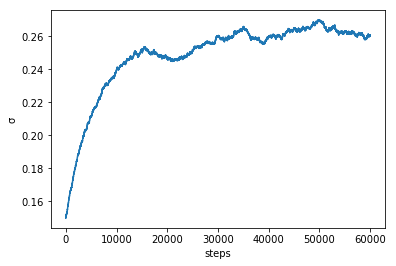

In [22]:
plt.xlabel('steps')
plt.ylabel('\u03C3')
plt.plot(sigmas)

In [23]:
print("Sigma[Mean]: {0} | Sigma[Std]: {1}".format(sigmas[-valid_sample:].mean(), sigmas[-valid_sample:].std()))

Sigma[Mean]: 0.2628034765043452 | Sigma[Std]: 0.002524590824909843


<h4>Verification of Result</h4>
<p>The sigma is found to be 0.263+-0.0025. The sigma is cross verified by conducting simulation to check if it could recover the option price.</p>

In [24]:
n = 10000
sigma = 0.263
payoffs = np.zeros(n)
for i in range(n):
    z = np.random.normal(size=len(t)-1)
    s = geometric_brownian_motion(z, t, s_0-initial_adjustment, mu, sigma)
    s_real = real_stock_price_movement(s, t, r, dividends, t_dividends)
    payoffs[i] = american_option_payoff(s_real, K, r, t, t_dividends, thresholds)
print("Price[Mean]: {0} | Price[Std]: {1}".format(payoffs.mean(), payoffs.std()))

Price[Mean]: 4.817728038877836 | Price[Std]: 6.563093700215117


<p>The simulated sample mean price of the option is close to the actual option price. It is reasonable to suggest that the sigma is indeed the implied volatility.</p>

<h4>Finite Difference Method for Gradient Sign Estimation</h4>

<p>This section attempts to use finite difference method to estimate the direction of the gradient for the gradient descent algorithm.</p>

In [25]:
#Problem Parameters
t = [0,0.3,0.6,0.9]
t_dividends = [0.3, 0.6]
t_expiration = 0.9
dividends = [2,2]
thresholds = [60, 60]
s_0 = 50. #starting price
K = 50 #exercise price
mu = 0.1
r = 0.1 #interest rate
initial_adjustment = get_dividend_adjustment([0], dividends, t_dividends, r)[0]
option_price = 4.85

In [26]:
#Simulation Parameters
sigma = 0.15
n = 60000
valid_sample = 10000
epilson = 1e-5
delta = 1e-5

In [27]:
result = np.zeros(n)
sigmas = np.zeros(n)
current_errors = np.zeros(n)
for i in range(n):
    z = np.random.normal(size=len(t)-1)
    result[i] = simulate_american_option_payoff(z, t, s_0-initial_adjustment, mu, sigma, r, K, dividends, t_dividends,thresholds)
    finite_difference = simulate_american_option_payoff(z, t, s_0-initial_adjustment, mu, sigma+delta, r, K, dividends, t_dividends,thresholds) - simulate_american_option_payoff(z, t, s_0-initial_adjustment, mu, sigma-delta, r, K, dividends, t_dividends,thresholds)
    current_error = (result[i] - option_price)
    current_errors[i] = current_error
    gradient_sign = np.sign(finite_difference)
    sigmas[i] = sigma
    sigma -= epilson*current_error*gradient_sign

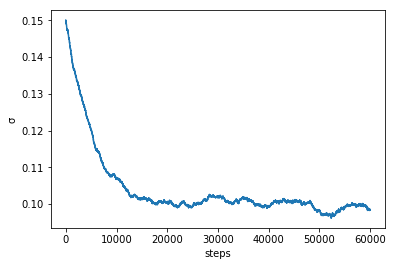

In [28]:
plt.xlabel('steps')
plt.ylabel('\u03C3')
plt.plot(sigmas)

In [29]:
price_mean = result[-valid_sample:].mean()
price_std = result[-valid_sample:].std()
print("Price[Mean]: {0} | Price[Std]: {1}".format(price_mean, price_std))

Price[Mean]: 2.0144823314478857 | Price[Std]: 2.8811208268580937


In [30]:
print("Sigma[Mean]: {0} | Sigma[Std]: {1}".format(sigmas[-valid_sample:].mean(), sigmas[-valid_sample:].std()))

Sigma[Mean]: 0.09855709716698625 | Sigma[Std]: 0.0011346897888715598


In [31]:
current_errors[-valid_sample:].mean()

-2.8355176685521144